## Locality-sensitive hashing (LSH) algorithm

Formally, LSH is an algorithm that finds approximate or exact duplicates in high dimensional spaces (e.g. images, documents, audio). The main idea of LSH is to use a group of functions to conduct similarity preserving hashing into "buckets". Using this approach, the nearest neighbours will land in the same bucket with high probability, and the data points that are distant from each other will very likely be hashed into different buckets. It is worth noting the difference to the classical hashing functions, which try to avoid collisions.

The general framework consists of the following steps:
1.   Feature extraction/dimensionality reduction (e.g. random hyperplanes technique with cosine distance (implemented below))
2.   AND/OR construction to report duplicate candidates
3.   Refinement - calculation of exact distance between candidates

For details, you can take a look at the implementation.

Using this method we ensure **correctness, but not completeness.** This means that the found duplicates are indeed duplicates (due to refinement step), but it is probable that we haven't found all of them. In big data, the success of an algorithm is ofter measured by its runtime. Omitting pairwise similarity computation, we reduce the runtime from exponential to linear w.r.t the number of data points.


Some of the exciting large scale use cases of LSH:
*   **Uber:** To detect fraudulent drivers, similar trips are detected based on their spatial properties. Switching from N^2 method to the LSH, the computation time decreased from 55 hours to just 4 hours.
*   **Google:** VisualRank - Google's image search technology uses LSH to find similar images at scale.
*   **Genome-wide association study:** LSH is used for finding similar gene expressions in genome databases
[https://eng.uber.com/lsh/]

## Duplicate reviews detection in Yelp dataset

Our goal is to identify duplicate reviews in Yelp dataset.

![alt text](https://is1-ssl.mzstatic.com/image/thumb/Purple118/v4/63/d7/f9/63d7f93a-bc7d-1388-48ab-fa4016ed4830/AppIcon-1x_U007emarketing-0-0-GLES2_U002c0-512MB-sRGB-0-0-0-85-220-0-0-0-6.png/246x0w.jpg)</br>
It could be useful to detect spam or very similar reviews written for many restarants. For this task, we are working with the reviews submitted to the restaurants in Las Vegas.

The data includes:
* The preprocessed (sparse) data matrix: [bow_subset.npz](https://syncandshare.lrz.de/dl/fiUuDugamX2JCH33hkxYXgdF)
* The words in the vocabulary: [top_25k_words.npy](https://syncandshare.lrz.de/dl/fiMX6taWPMEQ9aaznq4oadyq)
* Orginal raw data: [reviews_subset.json](https://syncandshare.lrz.de/dl/fiLLqkiVLXGQPnrj7UvLtBbN)

Implementation based on the programming task in the course Mining Massive Datasets (Year: 2018) at the Technical University of Munich 

### Import libraries

In [0]:
import numpy as np
import scipy.sparse as sp
import re
import json
import time
import cupy

from scipy.sparse import linalg as spl
from collections import defaultdict
from IPython.display import Markdown, display

import matplotlib.pyplot as plt
%matplotlib inline

### Loading data

In [0]:
words = np.load('top_25k_words.npy')
bow_subset = sp.load_npz('bow_subset.npz')
N = bow_subset.shape[0]

with open('reviews_subset.json' , 'r') as f:
    reviews = json.load(f)

The shape of the "bow-subset" data matrix should be $100K \times 25K$. There are $100K$ reviews, and each review is represented as bag-of-words vector of size $25K$. We can see also which words the dictionary consists of. At the position of a word, there is a number of occurences of the word in a given review.

In [151]:
print("The shape of the data matrix: ", bow_subset.shape)
print("The first word from the bag of words:", words[0])

The dimansionality of the data matrix:  (100000, 25000)
The first word from the bag of words: food


### Exemplary review from the raw dataset:

In [152]:
reviews[0]

{'biz': {'categories': ['Restaurants', 'Steakhouses'],
  'city': 'Las Vegas',
  'name': "Gallagher's Steakhouse"},
 'business_id': 'nnDLapJk1z2NJE0-XzwMlQ',
 'review_id': '0Lx-agcwqjNhS4JtCVqkHQ',
 'stars': 5,
 'text': "The surf and turf here was one of the best I've had.\n\nFilet mignon and lobster tail was very good.  i generally dont think the food in Vegas is great, but after being dissappointed on many occasions, I was pleasantly surprised with the quality of our meal.  Thanks to the Taste, i was lured to this restaurant only to find that it is a somehat hidden jewel in New York New York close to the sometimes obnoxious piana bar time square.  \n\nThe side of green beans were delish and the potatos are just meh.\n\nFor desert they  served an extremely delicious lemon pudding which taste more tart than pudding....it was fabulous.\n\nI think Gallaghers is good for couples, groups, and even kids.",
 'user_id': 'M63uPVZtCv7ReY2RgJRmOw'}

## Implementaion

The main task is to implement two functions that:
1.   Compute the cosine distance between two rows of a sparse matrix
2.   Conduct locality sensitive hashing

The LSH function will generate duplicate candidates based on $b$ bands and $r$ rows per band. Subsequently, it will compute the exact cosine distance between candidates and report the duplicates with cosine distance $<d$



### 1. The cosine distance between two sparse vectors using scipy.sparse.

<b>Parameters</b>:<br/>

<i>X</i> :  sp.spmatrix, shape [N, K] (Sparse data matrix)<br/>
<i>i</i> :  int (Index of the first row) <br/>
<i>j</i> :  int (Index of the second row) <br/>

<b>Return</b>: <br/> 
<i>d</i> :  float (Cosine distance between the two rows of the sparse matrix)


In [0]:
def cosine_distance(X, i, j):

    i_norm = spl.norm(X[i])
    j_norm = spl.norm(X[j])
    ij_dot = X[i].dot(X[j].T)[0, 0]

    return 1-ij_dot/(i_norm*j_norm)

### 2. Locality sensitive hashing

<b>Parameters</b>:<br/>

<i>X</i> :  sp.spmatrix, shape [N, K] (Sparse data matrix)<br/>
<i>b</i> :  int (Number of bands) <br/>
<i>r</i> :  int (Number of rows per band) <br/>

<b>Return</b>: <br/> 
<i>duplicates</i> :  {(ID1, ID2, d_{12}), ..., (IDX, IDY, d_{xy})}. A set of tuples containing: (ID of the 1. review), (ID of the 2. review), (The cosine distance between them)<br/>

<i>n_candidates</i> : int (Number of candidate pairs)

## CPU Version with Numpy

In [0]:
def LSH(X, b=8, r=32, d=0.3):

    np.random.seed(158)
    N, D = X.shape
    
    # Generate b*r x N matrix holding vectors for random projections in each row
    projection_vectors = np.random.normal(0.0, 1.0, (D, b*r))
    
    # conduct random projections
    random_projections = X.dot(projection_vectors)
    random_projections = np.reshape(random_projections, (N, b, r))
    random_projections = np.reshape(random_projections, (N, b, r))
    random_projections = random_projections >= 0
    
    # hash each band of random projections
    vals = 2**np.repeat([np.repeat([np.arange(r)], b, axis=0)], N, axis=0)
    hashed_values = np.multiply(random_projections, vals)
    hashed_values = np.sum(hashed_values, axis=2)

    
    # find candidates
    candidates = []
    for i in range(b):
        un_values, counts = np.unique(hashed_values[:, i], return_counts=True) # get unique integers and their count
        non_unique_values = un_values[counts > 1] # identify integers which appear more than once
        for val in non_unique_values: # store duplicate integers as candidates
            candidates.append(np.where(hashed_values[:, i] == val)[0])
    n_candidates = len(candidates)
    
    # get cosine distance for every candidate
    dist = [cosine_distance(X, cand[0], cand[1]) for cand in candidates] # get the distance for all candidates
    
    # get duplicates
    duplicates = set((candidates[i][0], candidates[i][1], dist[i]) for i in range(len(dist)) if dist[i] <= d ) 
    
    return duplicates, n_candidates

## GPU Version with CuPy #
This is a naive implementation with the CuPy library in an attempt to accelerate the computations even further. Unfortunately, the computation delivers unstable results. More on the topic: http://gamma.cs.unc.edu/KNN/gpuknn.pdf [Fast GPU-based Locality Sensitive Hashing for K-Nearest Neighbor Computation]

In [0]:
!apt -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!pip install cupy-cuda80 chainer

In [0]:
def LSH_GPU(X, b=8, r=32, d=0.3):

    cupy.random.seed()
    N, D = X.shape
    X = cupy.sparse.csr_matrix(X) # bow_subset is a csr sparse matrix (Compressed sparse row matrix)
    
    # Generate b*r x N matrix holding vectors for random projections in each row
    projection_vectors = cupy.random.normal(0.0, 1.0, (D, b*r))

    # Conduct random projections
    random_projections = X.dot(projection_vectors)
    random_projections = cupy.reshape(random_projections, (N, b, r))
    random_projections = cupy.reshape(random_projections, (N, b, r))    
    random_projections = random_projections >= 0
    
    
    # Hash each band of random projections
    vals = 2**np.repeat([np.repeat([np.arange(r)], b, axis=0)], N, axis=0)
    vals = cupy.array(vals)
    hashed_values = cupy.multiply(random_projections, vals)
    hashed_values = cupy.sum(hashed_values, axis=2)

    # Return to numpy  (Needed due to absence of equivalents of certain numpy libraries)
    X = bow_subset
    random_projections = cupy.asnumpy(random_projections)
    projection_vectors = cupy.asnumpy(projection_vectors)
    hashed_values = cupy.asnumpy(hashed_values)
    
    # find candidates
    candidates = []
    for i in range(b):
        un_values, counts = np.unique(hashed_values[:, i], return_counts=True) # get unique integers and their count (Function "unique" is currently missing in CuPy)
        non_unique_values = un_values[counts > 1] # identify integers which appear more than once
        for val in non_unique_values: # store duplicate integers as candidates
            candidates.append(np.where(hashed_values[:, i] == val)[0])
    n_candidates = len(candidates)
    
    # get cosine distance for every candidate
    dist = [cosine_distance(X, cand[0], cand[1]) for cand in candidates] # get the distance for all candidates
    
    # get duplicates
    duplicates = set((candidates[i][0], candidates[i][1], dist[i]) for i in range(len(dist)) if dist[i] <= d ) 
    
    return duplicates, n_candidates

#### Runtime comparison in seconds:

In [163]:
t1 = time.time()
duplicates, n_candidates= LSH(bow_subset, b=6, r=28, d=0.2)
print("(Runtime in seconds) LSH: ", time.time() - t1)

t1 = time.time()
duplicates_GPU, n_candidates_GPU= LSH_GPU(bow_subset, b=6, r=28, d=0.2)
print("(Runtime in seconds)  LSH_GPU: ",time.time() - t1)



(Runtime in seconds) LSH:  2.337021827697754
(Runtime in seconds)  LSH_GPU:  1.28721284866333


We can see a significant increase in the speed of computation. Implementation not based on numpy, containing many for-loops, took approximately 20 minutes to compute. 

In [164]:
print('We detected {} candidates.'.format(n_candidates))
print('We detected {} candidates (GPU).'.format(n_candidates_GPU))

We detected 771 candidates.
We detected 595 candidates (GPU).


#### Show the duplicates we have found:

In [165]:
print("Duplicates:")
duplicates

Duplicates:


{(1809, 13244, 0.0),
 (6600, 93310, 0.0),
 (17779, 72702, 1.1102230246251565e-16),
 (28508, 64525, 0.10912919362525197),
 (32066, 71726, 0.0),
 (35163, 82597, 1.1102230246251565e-16),
 (42795, 95179, 0.0),
 (47940, 65607, 0.0)}

In [166]:
print("Duplicates_GPU: ")
duplicates_GPU

Duplicates_GPU: 


{(1809, 13244, 0.0),
 (6600, 93310, 0.0),
 (42795, 95179, 0.0),
 (47940, 65607, 0.0)}

#### Retrieve original data for the detected reviews:

In [0]:
similar_review_pairs = []
for ix1, ix2, sim in duplicates:
    rev1 = reviews[ix1]
    rev2 = reviews[ix2]
    similar_review_pairs.append((rev1, rev2, sim))

#### Show the detected pairs with cosine distance > 0 (not exact duplicates), and highlight the words not present in the used bag-of-words.

In [0]:
pattern = re.compile('(\S+|\n)')
pattern_punctuation = re.compile('^\W+|\W+$')

def highlight_vocabulary(text, vocabulary):
    split = re.findall(r"[\w']+", text)
    in_vocabulary = [pattern.sub(lambda m: pattern_punctuation.sub('', m.group()), str.lower(x)) in words for x in split]
    highlighted_words = ["**{}**".format(x) if in_vocabulary[ix] else x for ix,x in enumerate(split) ]
    highlighted_text = " ".join(highlighted_words)
    return highlighted_text

def printmd(string):
    display(Markdown(string))

In [182]:
for r1, r2, sim in similar_review_pairs:
    if not np.isclose(sim, 0.0):
        print(highlight_vocabulary(r1['text'], words))
        print("")
        print("vs.")
        print("")
        print(highlight_vocabulary(r2['text'], words))
        print("===")
        print("Same business: {}".format(r1['business_id'] == r2['business_id']))
        print("Same user: {}".format(r1['user_id'] == r2['user_id']))
        print("Cosine distance {:.4f}".format(sim))
        print("")    
        print("#######")
        print("")

**Good** **food** **Good** **music** **Good** **service** All goooodddddddd I **love** it This **restaurant** is so **good** **1**

vs.

**Good** **Service** **Good** **food**
===
Same business: False
Same user: False
Cosine distance 0.1091

#######



## Intractability of the pairwise naive cosine distance computation between all reviews

We can optionally verify that a naive nearest neighbour search is infeasible given the dataset of this size. **Warning: running this code may freeze your machine!**


In [0]:
# from sklearn.metrics.pairwise import pairwise_distances
# distances = pairwise_distances(bow_subset, metric='cosine')

## Runtime comparison
To compare runtimes, a naive for-loop implementation is provided. It helps with the memory issues and takes $O(N^2)$ time.

<b>Parameters</b>:<br/>

<i>X</i> :  sp.spmatrix, shape [N, K] (Sparse data matrix)<br/>
<i>d</i> :  float (Distance treshold for reporting duplicates) <br/>


<b>Return</b>: <br/> 
<i>duplicates</i> :  {(ID1, ID2, d_{12}), ..., (IDX, IDY, d_{xy})}. A set of tuples containing: (ID of the 1. review), (ID of the 2. review), (The cosine distance between them)<br/>

In [0]:
def naive_duplicates(X, d = 0.2):

    N = X.shape[0]
    duplicates = set()
    for i in range(N):
        for j in range(N):
            d_ij = cosine_distance(X, i, j)
            if d_ij < d and i != j:
                duplicates.add((i, j, d_ij))
                
    return duplicates

In [0]:
def runtime_comparison():

    trace = []
    for n in np.arange(25, 251, 25):
        print('Running comparison for {} reviews.'.format(n))
        t = time.time()
        LSH(bow_subset[:n], b=6, r=28, d=0.2)
        t_lsh = time.time() - t
        t = time.time()
        naive_duplicates(bow_subset[:n], d=0.2)
        t_naive = time.time() - t
        
        trace.append((n, t_lsh, t_naive))
        
    return trace  

In [0]:
trace = runtime_comparison()

We plot the runtime w.r.t the number of analysed reviews. We see an exponential growth of runtime in naive implementation. The blue line represents the LSH algorithm. The test set is too small to see any growth in computation time for LSH. (It took about 2 seconds to compute 100.000 reviews)

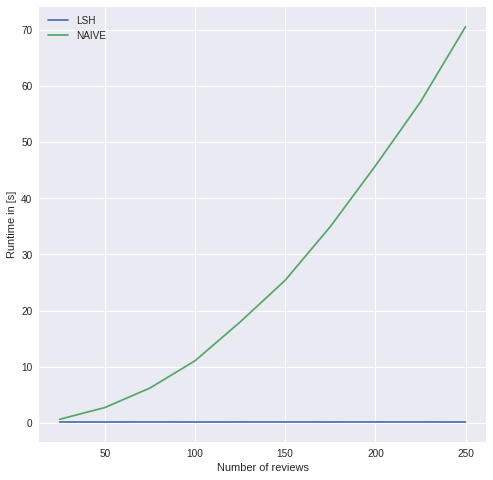

In [179]:
x = np.arange(25, 251, 25)
plt.figure(figsize=[8, 8])
plt.plot(x, [tr[1] for tr in trace], label='LSH') # LSH
plt.plot(x, [tr[2] for tr in trace], label='NAIVE') # NAIVE
plt.ylabel('Runtime in [s]')
plt.xlabel('Number of reviews')
plt.legend()
plt.show()